Mega-Amp Spherical Tokamak
==========================

An example of a dead start (from scratch) for the MAST tokamak. A solution to the Grad-Shafranov equation requires 

1. A definition of the locations of the poloidal field coils, and how they are wired together, for example connected in series to the same power supplies. This is specific to the machine.
2. Plasma profiles of pressure and current, p(psi) and f(psi), together with global contraints such as total plasma current, which indirectly specify the size of the plasma.
3. A control system which sets the shape and location of the plasma. Like a real plasma, feedback control is needed to stabilise vertical and radial motion in free-boundary Grad-Shafranov solvers.


In [2]:
# Step 1: Specify the locations of the coils, and the domain you want to solve over

from freegs import machine
from freegs.equilibrium import Equilibrium

# Define the poloidal field coil set
tokamak = machine.MAST()

# Define the domain to solve over
eq = Equilibrium(tokamak=tokamak,
                 Rmin=0.1, Rmax=2.0,    # Radial domain
                 Zmin=-2.0, Zmax=2.0,   # Height range
                 nx=65, ny=65)        # Number of grid points

Define toroidal current function. The RHS of the Grad-Shafranov equation is determined by the toroidal current density

$j_{tor} = -R\frac{\partial p}{\partial \psi} - \frac{1}{\mu_0 R}f\frac{\partial p}{\partial \psi}$

The profiles can be adjusted to match global constrants, such as the pressure on axis and the total plasma current $I_p$

The toroidal current function jtor_func calculates the toroidal current density $j_{tor}$ given $\psi$ on an R-Z mesh

In [4]:
# Step 2: Specify the profiles of pressure and f=R*Bt. 
# Currently quite simple functions are supported

from freegs.jtor import ConstrainPaxisIp

profiles = ConstrainPaxisIp(eq,  # Equilibrium
                            3e3, # Plasma pressure on axis [Pascals]
                            7e5, # Plasma current [Amps]
                            0.4) # vacuum f = R*Bt

In [5]:
# Step 3: Specify the control system and feedback variables.
# The control system adjusts the currents in the poloidal field coils
# to produce X-points in the desired locations, and ensure that the desired
# pairs of locations have the same poloidal flux.

from freegs import control

xpoints = [(0.7, -1.1),   # (R,Z) locations of X-points
           (0.7, 1.1)]

# Contstrain these pairs of (R,Z, R,Z) locations to have the same poloidal flux
# This is needed for radial and vertical position control of the plasma.
isoflux = [(0.7,-1.1, 1.45, 0.0)   # Lower X-point, Outboard midplane
           ,(0.7,1.1, 1.45, 0.0)   # Upper X-point, Outboard midplane
          ]

constrain = control.constrain(xpoints=xpoints, gamma=1e-12, isoflux=isoflux)

constrain(eq)

In [6]:
# With these three components (coils, profiles and constraints), solve the nonlinear
# system with a Picard iteration. This modifies the "eq" object.

from freegs import picard

picard.solve(eq,           # The equilibrium to adjust
             profiles,     # The toroidal current profile function
             constrain)    # Constraint function to set coil currents

In [7]:
print("Plasma current: %e Amps" % (eq.plasmaCurrent()))

Plasma current: 7.000000e+05 Amps


In [8]:
tokamak.printCurrents()

P2U : Coil(R=0.49, Z=1.76, current=15747.4, turns=1, control=True)
P2L : Coil(R=0.49, Z=-1.76, current=15753.4, turns=1, control=True)
P3U : Coil(R=1.1, Z=1.1, current=20661.3, turns=1, control=True)
P3L : Coil(R=1.1, Z=-1.1, current=20698.4, turns=1, control=True)
P4U : Coil(R=1.51, Z=1.095, current=-35651.0, turns=1, control=True)
P4L : Coil(R=1.51, Z=-1.095, current=-35610.7, turns=1, control=True)
P5U : Coil(R=1.66, Z=0.52, current=-148015.1, turns=1, control=True)
P5L : Coil(R=1.66, Z=-0.52, current=-147859.4, turns=1, control=True)
P6U : Coil(R=1.5, Z=0.9, current=-62154.2, turns=1, control=True)
P6L : Coil(R=1.5, Z=-0.9, current=-62362.4, turns=1, control=True)
P1 : Solenoid(Rs=0.15, Zsmin=-1.4, Zsmax=1.4, current=-90200.53918457031, Ns=100, control=True)


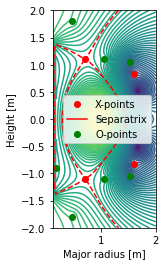

<AxesSubplot:xlabel='Major radius [m]', ylabel='Height [m]'>

In [9]:
%matplotlib inline

from freegs.plotting import plotEquilibrium
plotEquilibrium(eq)

Modifying the equilibrium
-------------------------

Modify the constraints for the X-point locations and isoflux pairs. Starting from the previous solution, this quite quickly finds a new solution.

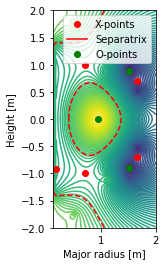

<AxesSubplot:xlabel='Major radius [m]', ylabel='Height [m]'>

In [10]:
xpoints = [(0.7, -1.0),   # (R,Z) locations of X-points
           (0.7, 1.0)]

isoflux = [(0.7,-1.0, 1.4, 0.0),(0.7,1.0, 1.4, 0.0), (0.7,-1.0, 0.3, 0.0)]

constrain = control.constrain(xpoints=xpoints, gamma=1e-12, isoflux=isoflux)

constrain(eq)

plotEquilibrium(eq)

In [11]:
picard.solve(eq,           # The equilibrium to adjust
             profiles,    # The toroidal current profile function
             constrain)    # Constraint function to set coil currents

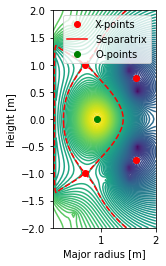

<AxesSubplot:xlabel='Major radius [m]', ylabel='Height [m]'>

In [12]:
plotEquilibrium(eq)